# Reconstruction of the COSMOS survey

In this notebook, we apply the probabilistic mapping framework to COSMOS data from [Schrabback et al. 2010](https://arxiv.org/abs/0911.0053). 

In [2]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [1]:
from astropy.io import fits
import tensorflow as tf
from jax_lensing.spectral import measure_power_spectrum
from jax_lensing.inversion import ks93, ks93inv
import jax.numpy as jnp

In [4]:
# These show the borders of the cosmos field
COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]

from lenspack.geometry.projections import gnom
def get_extend_radec():
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size=0.4 #arcmin
    dx = np.deg2rad(320*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

In [7]:
# Load mask from COSMOS
mask = fits.getdata('../data/cosmos_mask_0.4arcmin.fits').astype('float32')
# Load shear maps from COSMOS
meas_shear = fits.getdata('../data/cosmos_e_0.4arcmin.fits').astype('float32')

## Standard Kaiser-Squires inversion

In [8]:
ksmap,_ = ks93(meas_shear[...,0], meas_shear[...,1])

/local/home/flanusse/.local/lib/python3.8/site-packages/jax/lib/xla_bridge.py:130: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')


In [12]:
# And let's apply some smoothing
from scipy.ndimage import gaussian_filter
gauss_ksmap = gaussian_filter(ksmap, 3) # 3 pixels corresponds to 1.2 arcmin

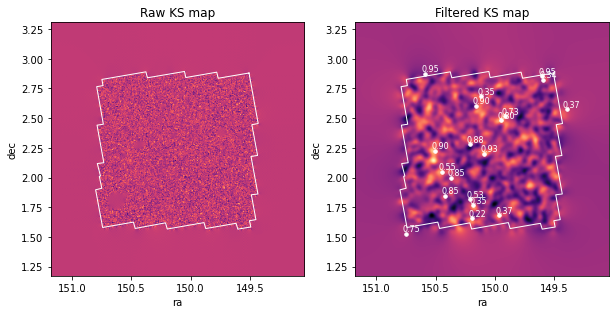

In [17]:
figure(figsize=[10,5])
subplot(121)
imshow(ksmap,cmap='magma', 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
title('Raw KS map')

subplot(122)
imshow(gauss_ksmap,cmap='magma', 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
title('Filtered KS map')

xclusters = np.loadtxt("../data/xray.txt")
m500min=3
zmin=0.1
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        scatter(ra_cl, dec_cl, c='w', s=12)
        text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')

(1.57, 2.9)

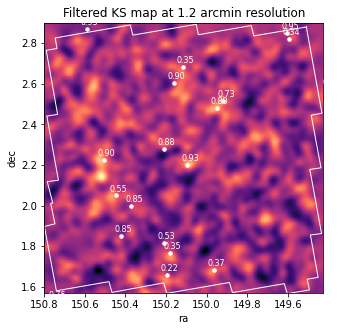

In [24]:
# Let's zoom in on this map
figure(figsize=[5,5])
imshow(gauss_ksmap,cmap='magma', 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
title('Filtered KS map at 1.2 arcmin resolution')

xclusters = np.loadtxt("../data/xray.txt")
m500min=3
zmin=0.0
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        scatter(ra_cl, dec_cl, c='w', s=12)
        text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')
# Restrict to extent of Massey paper    
ra_min, ra_max = (149.425, 150.8)
dec_min, dec_max = (1.57, 2.9)
xlim(ra_max, ra_min)
ylim(dec_min, dec_max)

## Probabilistic mapping

### Gaussian mapping

Sampling is done with:
```
$ python scripts/sample_maps.py --shear=data/cosmos_e_0.4arcmin.fits --mask=data/cosmos_mask_0.4arcmin.fits --model_weights=/data/Scores/lensing/training_kl1_gaussian_01noise/model-final.pckl  --gaussian_only=True
```

In [13]:
# And load the results of the sampling
s = fits.getdata('../samples.fits').astype('float32')

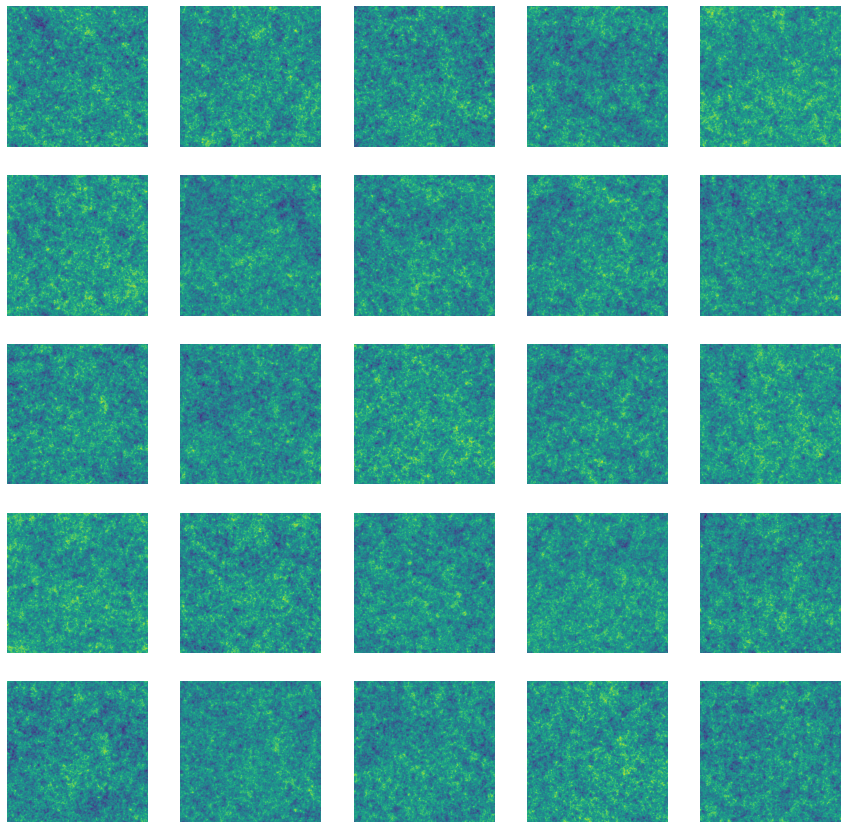

In [15]:
figure(figsize=[15,15])
for i in range(5):
    for j in range(5):
        subplot(5, 5, i*5+j+1)
        imshow(s[-1,i*5+j].reshape((320,320)))
        axis('off')

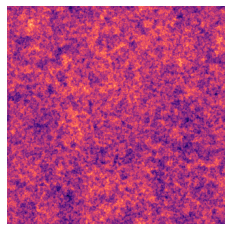

In [16]:
files = []
for i in range(32):
    plt.cla()
    im = s[-1, i].reshape((320, 320))[:,::-1]
    imshow(im,cmap='magma',vmin=s[-1].min(), vmax=s[-1].max(), 
           origin='lower')
    axis('off')
    fname = '_tmp%03d.png' % i
    plt.savefig(fname,dpi=300)
    files.append(fname)

In [ ]:
# And now you can make a movie with:
# ffmpeg -r 10 -f image2  -i _tmp%3d.png -vcodec libx264 -crf 15 movie_cosmos.mp4

Text(0.5, 1.0, 'std')

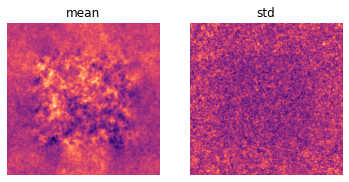

In [44]:
subplot(121)
imshow(s[-1].mean(axis=0).reshape((320,320))[:,::-1],cmap='magma',
       origin='lower')
axis('off')
title('mean')
subplot(122)
imshow(s[-1].std(axis=0).reshape((320,320))[:,::-1],cmap='magma',
       origin='lower')
axis('off')
title('std')

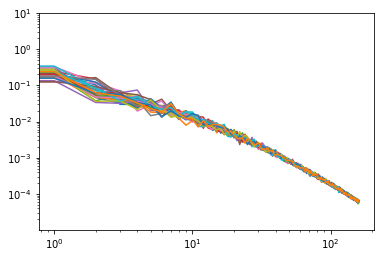

In [33]:
for i in range(32):
    loglog(measure_power_spectrum(s[-1,i].reshape((320,320))))

### ML mapping

In [28]:
# We can also sample this time using the ML prior
s1 = fits.getdata('../samples_ml.fits').astype('float32')
s2 = fits.getdata('../samples_ml_.fits').astype('float32')
s3 = fits.getdata('../gpu1_samples_ml_1.fits').astype('float32')
s4 = fits.getdata('../gpu2_samples_ml_1.fits').astype('float32')
s5 = fits.getdata('../gpu1_samples_ml_2.fits').astype('float32')
s6 = fits.getdata('../gpu2_samples_ml_2.fits').astype('float32')
s7 = fits.getdata('../gpu1_samples_ml_3.fits').astype('float32')
s8 = fits.getdata('../gpu2_samples_ml_3.fits').astype('float32')
s9 = fits.getdata('../gpu1_samples_ml_4.fits').astype('float32')
s10 = fits.getdata('../gpu2_samples_ml_4.fits').astype('float32')
s11 = fits.getdata('../gpu2_samples_ml_5.fits').astype('float32')
s12 = fits.getdata('../gpu2_samples_ml_6.fits').astype('float32')
s13 = fits.getdata('../gpu2_samples_ml_7.fits').astype('float32')
s14 = fits.getdata('../gpu2_samples_ml_8.fits').astype('float32')
s15 = fits.getdata('../gpu2_samples_ml_9.fits').astype('float32')
s16 = fits.getdata('../gpu2_samples_ml_10.fits').astype('float32')

In [29]:
s = np.concatenate([s1,s2,s3,s4,s5,s6,s7,s8,s9,s10,s12,s12,s13,s14,s15,s16], axis=1)

In [30]:
s.shape

(2, 64, 102400)

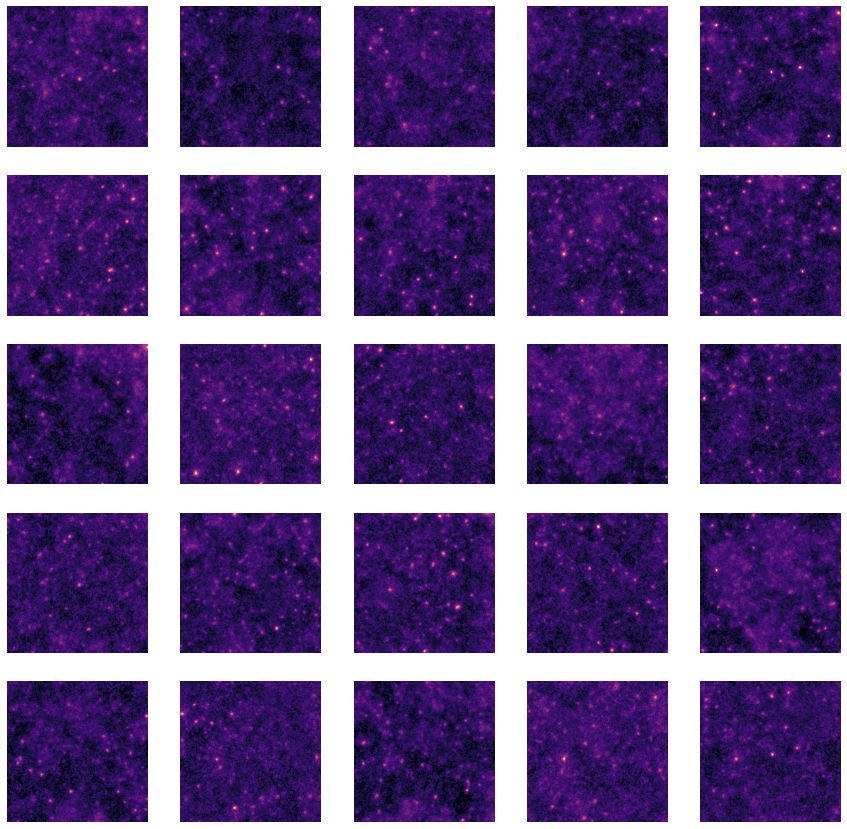

In [31]:
figure(figsize=[15,15])
for i in range(5):
    for j in range(5):
        subplot(5, 5, i*5+j+1)
        imshow(((s[-1,i*5+j].reshape((320,320))))[:,::-1][160-128:160+128,
                                                     160-128:160+128], 
               cmap='magma',origin='lower', vmin=-0.05, vmax=0.25)
        axis('off')
        

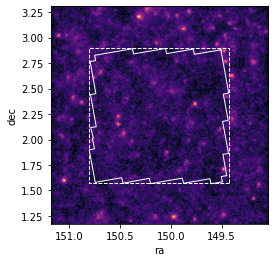

In [32]:
# Export frames for movie
files = []
for i in range(64):
    plt.cla()
    im = s[-1, i].reshape((320, 320))
    imshow(im,cmap='magma',vmin=-0.05, vmax=0.25, 
           origin='lower', extent=get_extend_radec())
    xlim(gca().get_xlim()[::-1])
    ra, dec = np.array(COSMOS_VERTICES).T
    plot(ra, dec,  c='w', lw=1)
    xlabel('ra')
    ylabel('dec')
    # Draw borders from Massey
    ra_min, ra_max = (149.425, 150.8)
    dec_min, dec_max = (1.57, 2.9)
    ra = [ra_min, ra_max, ra_max, ra_min, ra_min]
    dec = [dec_min, dec_min, dec_max, dec_max, dec_min]
    plot(ra, dec, '--', c='w', lw=1)
    
    fname = '_tmp%03d.png' % i
    plt.savefig(fname,dpi=300)
    files.append(fname)

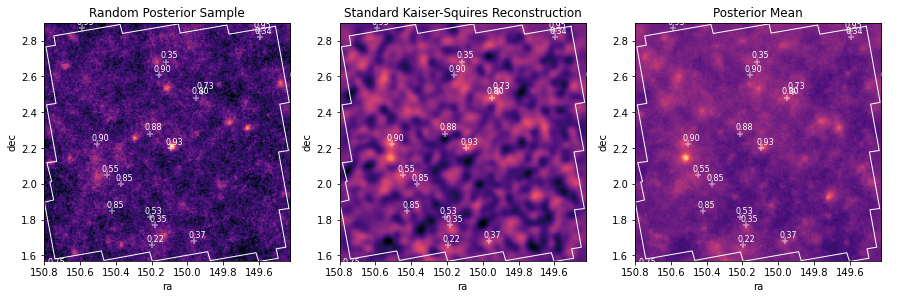

In [134]:
figure(figsize=[15,5])

xclusters = np.loadtxt("../data/xray.txt")
m500min=3
zmin=0.0
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)

subplot(131)
title('Random Posterior Sample')
im = s[-1, 0].reshape((320, 320))
imshow(im,cmap='magma',vmin=-0.05, vmax=0.2,
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
xlim(ra_max, ra_min)
ylim(dec_min, dec_max)

for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        scatter(ra_cl, dec_cl, c='w', s=30,marker='+',alpha=0.5)
        text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')

subplot(132)
title('Standard Kaiser-Squires Reconstruction')
imshow(gauss_ksmap,cmap='magma',vmin=-0.05, vmax=0.1,
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
xlim(ra_max, ra_min)
ylim(dec_min, dec_max)

for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        scatter(ra_cl, dec_cl, c='w', s=30,marker='+',alpha=0.5)
        text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')


subplot(133)
title('Posterior Mean')
imshow(mean(s[-1],axis=0).reshape((320,320)),
       cmap='magma',vmin=-0.05, vmax=0.1, 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
xlim(ra_max, ra_min)
ylim(dec_min, dec_max)



for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        scatter(ra_cl, dec_cl, c='w', s=30,marker='+',alpha=0.5)
        text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')
# subplot(144)
# title('Posterior Standard Deviation')
# imshow(std(s[-1],axis=0).reshape((320,320)),
#        cmap='magma', vmax=0.1, 
#        origin='lower', extent=get_extend_radec())
# xlim(gca().get_xlim()[::-1])
# ra, dec = np.array(COSMOS_VERTICES).T
# plot(ra, dec,  c='w', lw=1)
# xlabel('ra')
# ylabel('dec')
# xlim(ra_max, ra_min)
# ylim(dec_min, dec_max)
savefig('cosmos_reconstruction.pdf', bbox_inches='tight', pad_inches=0)

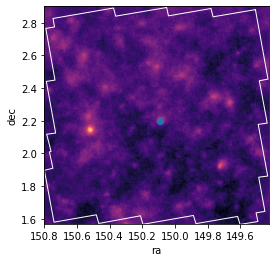

In [137]:
imshow(mean(s[-1],axis=0).reshape((320,320)),
       cmap='magma', vmax=0.1, 
       origin='lower', extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
xlim(ra_max, ra_min)
ylim(dec_min, dec_max)

# Finding out where the central cluster is
xclusters = np.loadtxt("../data/xray.txt")
m500min=3
zmin=0.93
zmax=0.93
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
cluster = xclusters[highz][0]
ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
scatter(ra_cl, dec_cl)

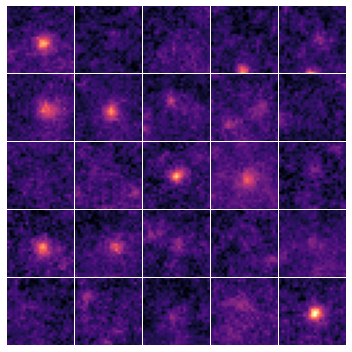

In [138]:
figure(figsize=[5,5])
for i in range(5):
    for j in range(5):
        subplot(5,5,i*5+j+1)
        imshow(s[-1][i*5+j].reshape((320,320)),
               cmap='magma', vmax=0.25, vmin=-0.05,
               origin='lower', extent=get_extend_radec())
        xlim(gca().get_xlim()[::-1])
        axis('off')
        #scatter(ra_cl, dec_cl,c='w',marker='+',s=1000)
        size = 10/60. # 10 arcmin
        xlim(ra_cl+size/2, ra_cl-size/2)
        ylim(dec_cl+size/2, dec_cl-size/2)
tight_layout()
subplots_adjust(wspace=0.02,hspace=0.02)
savefig('cosmos_cluster_focus.pdf', bbox_inches='tight', pad_inches=0)

In [112]:
# Let's investigate the significativity of the center cluster
data = s[-1].reshape((-1,320,320))
# Retrieve postage stamp at the center for 16 random maps
data0 = data[:, 160-16:160+16, 160-16:160+16]

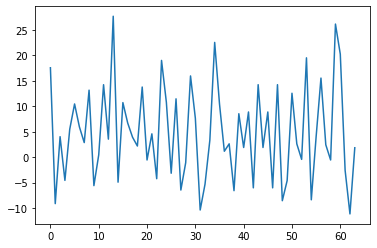

In [119]:
plot(data0.sum(axis=1).sum(axis=1))

In [ ]:
imshow

In [71]:
data = data0.reshape([4,4,64,64]).transpose([0,2,1,3]).reshape([4*64,4*64])

(0.0, 256.0, 0.0, 256.0)

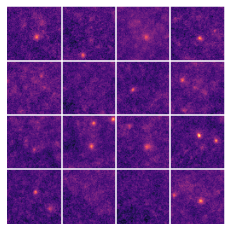

In [72]:
imshow(data[:,::-1] ,cmap='magma', origin='lower')
for i in range(4):
    axvline(64*(i+1),c='w')
    axhline(64*(i+1),c='w')
xlim(0,4*64)
ylim(0,4*64)
axis('off')

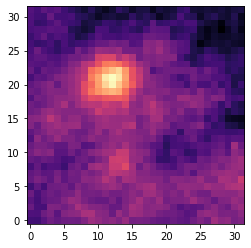

In [114]:
imshow(data0[:,::-1].mean(0),cmap='magma', origin='lower' )

In [80]:
xclusters

array([[3.0000000e+00, 1.5080244e+02, 1.9898500e+00, ..., 5.6000000e-01,
        6.0000000e-02, 1.0000000e+00],
       [9.0000000e+00, 1.5075121e+02, 1.5279300e+00, ..., 2.6200000e+00,
        2.3000000e-01, 1.0000000e+00],
       [1.1000000e+01, 1.5073676e+02, 2.8268000e+00, ..., 1.0600000e+00,
        1.0000000e-01, 1.0000000e+00],
       ...,
       [1.3400000e+02, 1.4960148e+02, 2.8508700e+00, ..., 1.5800000e+00,
        1.1000000e-01, 1.0000000e+00],
       [1.4000000e+02, 1.4948149e+02, 2.5178500e+00, ..., 3.5000000e-01,
        3.0000000e-02, 0.0000000e+00],
       [1.4500000e+02, 1.4939739e+02, 2.5748000e+00, ..., 3.9800000e+00,
        4.0000000e-02, 0.0000000e+00]])

In [81]:
xclusters = np.loadtxt("../data/xray.txt")
m500min=3
zmin=0.93
zmax=0.93
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)

In [85]:
# Finding coordinates of central cluster
cluster = xclusters[highz][0]
ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]

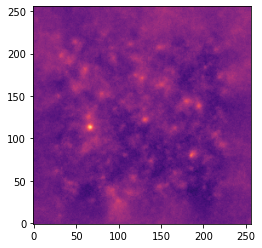

In [33]:
imshow(((s[-1].mean(axis=0).reshape((320,320))))[:,::-1][160-128:160+128,
                                             160-128:160+128], 
       cmap='magma',origin='lower', vmin=-0.05, vmax=0.1)

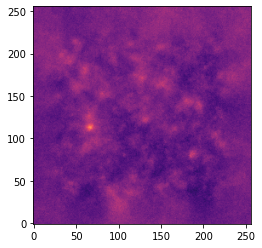

In [34]:
imshow(((median(s[-1],axis=0).reshape((320,320))))[:,::-1][160-128:160+128,
                                             160-128:160+128], 
       cmap='magma',origin='lower', vmin=-0.05, vmax=0.1)

In [83]:
vmax=s[-1].mean(axis=0).reshape((320,320))[160-128:160+128,
                                             160-128:160+128][:,::-1].max()

Text(0.5, 1.0, 'std')

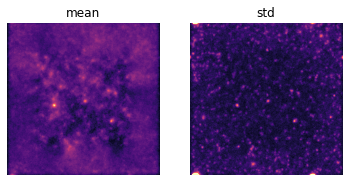

In [84]:
subplot(121)
imshow(s[-1].mean(axis=0).reshape((320,320))[:,::-1],cmap='magma',
       origin='lower',vmax=vmax)
axis('off')
title('mean')
subplot(122)
imshow(s[-1].std(axis=0).reshape((320,320))[:,::-1],cmap='magma',
       origin='lower',vmax=vmax)
axis('off')
title('std')

In [85]:
from astropy.io import fits
fits.writeto('cosmos_ml_mean.fits', s[-1].mean(axis=0).reshape((320,320)),overwrite=True)
fits.writeto('cosmos_ml_std.fits', s[-1].std(axis=0).reshape((320,320)),overwrite=True)
fits.writeto('cosmos_ml_samples.fits', s[-1].reshape((40,320,320)),overwrite=True)

In [86]:
from lenspack.geometry.projections import gnom
def get_extend_radec():
    ra0, dec0 = (150.11, 2.24) # from cosmos.astro.caltech.edu (could also just use the medians of positions)
    proj = gnom.projector(ra0, dec0)
    pix_size=0.4 #arcmin
    dx = np.deg2rad(320*pix_size/60./2) # number of degrees across
    dy = dx
    extent_xy = [-dx, dx, -dy, dy]
    ra_min, dec_min = proj.xy2radec(-dx, -dy)
    ra_max, dec_max = proj.xy2radec(dx, dy)
    extent_radec = [ra_min, ra_max, dec_min, dec_max]
    return extent_radec

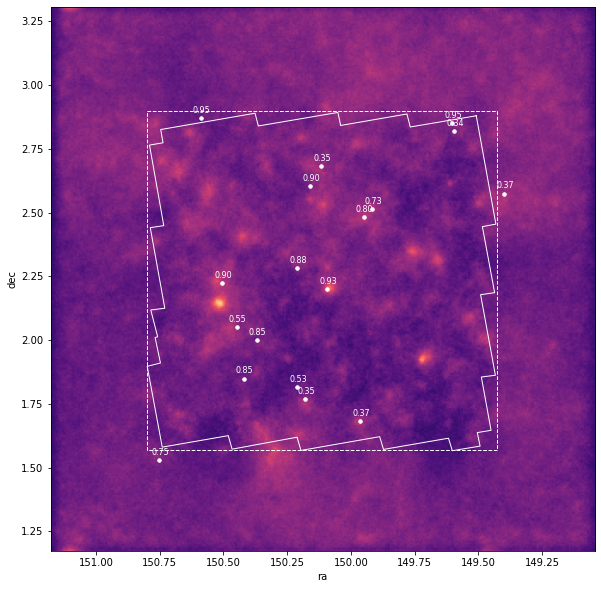

In [87]:
figure(figsize=(10,10))
imshow(((s[-1].mean(axis=0).reshape((320,320)))), 
       cmap='magma', origin='lower',
       vmin=-0.05, vmax=0.1, extent=get_extend_radec())
xlim(gca().get_xlim()[::-1])
ra, dec = np.array(COSMOS_VERTICES).T
plot(ra, dec,  c='w', lw=1)
xlabel('ra')
ylabel('dec')
# Draw borders from Massey
ra_min, ra_max = (149.425, 150.8)
dec_min, dec_max = (1.57, 2.9)
ra = [ra_min, ra_max, ra_max, ra_min, ra_min]
dec = [dec_min, dec_min, dec_max, dec_max, dec_min]
plot(ra, dec, '--', c='w', lw=1)

xclusters = np.loadtxt("../data/xray.txt")
m500min=3
zmin=0.3
zmax=0.99
highz = (xclusters[:, 6] >= zmin) & (xclusters[:, 6] <= zmax)
for cluster in xclusters[highz]:
    ra_cl, dec_cl, z_cl = cluster[1], cluster[2], cluster[6]
    m500 = cluster[7]
    if m500 > m500min:
        scatter(ra_cl, dec_cl, c='w', s=12)
        text(ra_cl + 0.03, dec_cl + 0.02, "{:.2f}".format(z_cl), fontsize=8, c='w')

In [37]:
import numpy as np

COSMOS_VERTICES = [(149.508, 2.880),
                   (149.767, 2.836),
                   (149.780, 2.887),
                   (150.040, 2.842),
                   (150.051, 2.893),
                   (150.363, 2.840),
                   (150.376, 2.890),
                   (150.746, 2.826),
                   (150.737, 2.774),
                   (150.790, 2.765),
                   (150.734, 2.449),
                   (150.787, 2.441),
                   (150.730, 2.125),
                   (150.785, 2.118),
                   (150.758, 2.013),
                   (150.768, 2.010),
                   (150.747, 1.910),
                   (150.799, 1.897),
                   (150.740, 1.580),
                   (150.481, 1.625),
                   (150.466, 1.572),
                   (150.211, 1.619),
                   (150.196, 1.567),
                   (149.887, 1.621),
                   (149.872, 1.571),
                   (149.617, 1.615),
                   (149.602, 1.566),
                   (149.493, 1.584),
                   (149.504, 1.637),
                   (149.450, 1.646),
                   (149.488, 1.855),
                   (149.433, 1.862),
                   (149.491, 2.178),
                   (149.436, 2.186),
                   (149.484, 2.445),
                   (149.431, 2.455),
                   (149.508, 2.880)]


def draw_footprint(ax, c='w', lw=1, **kwargs):
    """Draw the COSMOS field footprint on a plot.

    Parameters
    ----------
    ax : matplotlib.axes
        Space to draw on.
    c : str
        Color of the line. Default is white.
    lw : float
        Width of the line. Default is 1.
    """
    ra, dec = np.array(COSMOS_VERTICES).T
    ax.plot(ra, dec, c=c, lw=lw, **kwargs)


def draw_massey_outline(ax, c='w', lw=1, **kwargs):
    """Draw the border of the reconstruction field from Massey et al. 2007.

    Parameters
    ----------
    ax : matplotlib.axes
        Space to draw on.
    c : str
        Color of the line. Default is white.
    lw : float
        Width of the line. Default is 1.
    """
    ra_min, ra_max = (149.425, 150.8)
    dec_min, dec_max = (1.57, 2.9)
    ra = [ra_min, ra_max, ra_max, ra_min, ra_min]
    dec = [dec_min, dec_min, dec_max, dec_max, dec_min]
    ax.plot(ra, dec, c=c, lw=lw, **kwargs)